In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from utils.PINNnet import PINN
from utils.functions import green
from utils.plot_func import plot_field, model_pred_green, plot_error, model_pred

In [2]:
## hyperparameter
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5

In [3]:
import joblib
state_dict = joblib.load('model_green.joblib')
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.load_state_dict(state_dict)
model = model.to(device)

In [4]:
# fixed parameters
N = 100
L = 1
Lx, Ly = L, L
L_pml = 0.4
src = [-0.4, 0.4]
src_imag = [src[0], 2 - src[1]]
k = 2 * np.pi * 20 / 1500 * 100
strentch = 5

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


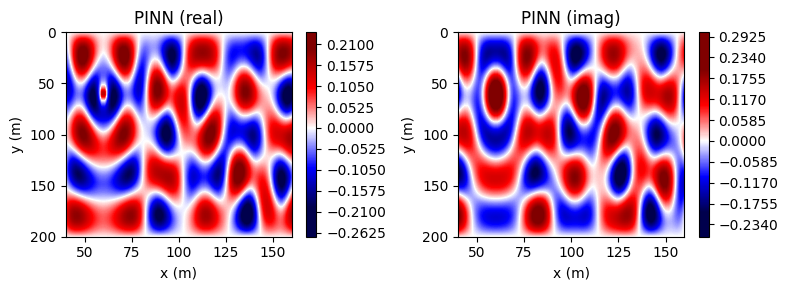

In [6]:
model_pred_green(model, Lx, Ly, L_pml, strentch=strentch, src=src, k=k, guide_mode='ideal', is_inverse=False)
#model_pred(model, Lx, Ly, L_pml, guide_mode='ideal', is_inverse=False)

In [7]:
x, y = torch.linspace(-(Lx - L_pml), (Lx - L_pml), N), torch.linspace(-Ly, Ly, N)
x, y = np.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)

g = green(x, y, src, k=k, strentch=5, is_tensor=False)
p_ref = g
for n in range(1000):
    i = n + 0.0
    x1, x2 = (-1)**i * (2 * i + 1.6), (-1)**(i+1) * (2 * (i+1) + 0.4)
    p_ref += (-1)**(i+1)*(green(x, y, [src[0], x1], k=k, strentch=5, is_tensor=False) + green(x, y, [src[0], x2], k=k, strentch=5, is_tensor=False))
p_ref_real, p_ref_imag = p_ref[:, 0].reshape(N, N), p_ref[:, 1].reshape(N, N)
p_ref = p_ref_real + 1j * p_ref_imag

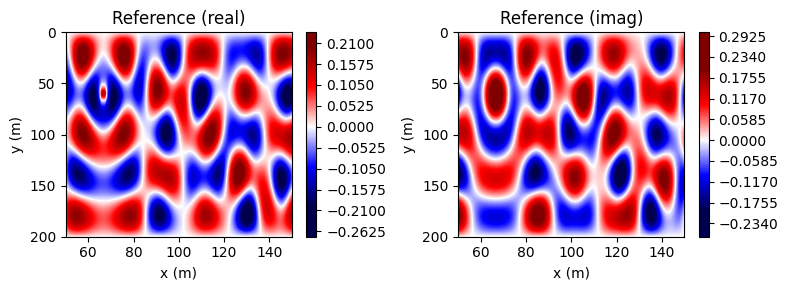

In [8]:
plot_field(p_ref, [50, 150], [-200, 0], bar_max=0.2, title='Reference', filename='Reference')

In [9]:
x, y = torch.tensor(x), torch.tensor(y)
g = green(x, y, src, k, strentch=5, device='cpu').numpy()
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = model(inputs)[:, 0:1].detach().numpy()
p_imag = model(inputs)[:, 1:2].detach().numpy()
p_real, p_imag = p_real.reshape(N, N) + g[:, 0].reshape(N, N), p_imag.reshape(N, N) + g[:, 1].reshape(N, N)
p = p_real + 1j * p_imag

Error(Real) 0.01602969691157341, Error(Imag) 0.01693626306951046


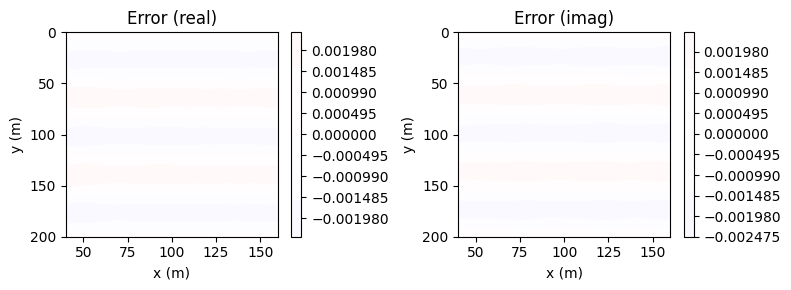

In [10]:
plot_error(p, p_ref, x, y)

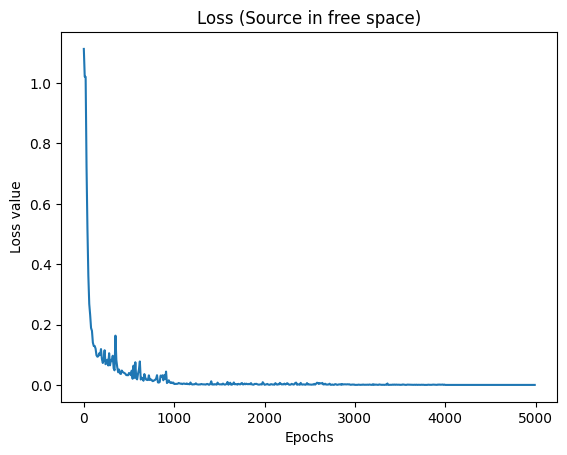

In [11]:
loss = np.load('loss.npy')
loss = loss.tolist()

selected_loss = [loss[i] for i in range(9, len(loss), 10)]

plt.plot(10*np.arange(0, len(selected_loss)), selected_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Loss (Source in free space)')
plt.savefig('loss')